In [1]:
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cleaned_financial_data.csv')
df = df.fillna(0)
df = df.drop(columns = ['Revenue', 'Difference between normalised pat and pat reported by company', 'Deposits (accepted by commercial banks)'])

In [3]:
df.columns

Index(['Name', 'Company code', 'Total income', 'Sales', 'Sales returns',
       'Net sales', 'Sales / Net fixed assets', 'Change in stock',
       'Total expenses', 'Profit after tax',
       'Profit after tax reported by company', 'PBDITA', 'PBPT', 'PBT', 'PBIT',
       'Cash profit', 'Depreciation as % of PBDITA',
       'Amortisation as % of PBDITA', 'PAT as % of PBDITA',
       'Total liabilities', 'Total capital', 'Reserves and funds',
       'Capital, debt, investment & other reserves',
       'Surplus/deficit as at the end of the year',
       'Retained profits/losses during the year', 'Non-current liabilities',
       'Long term borrowings excl current portion',
       'Long term debentures and bonds',
       'Interest accrued and due (long term) on borrowings',
       'Long term fixed deposits', 'Other long term borrowings',
       'Other long term liabilities', 'Current liabilities & provisions',
       'Current liabilities', 'Short-term borrowings',
       'Short term debent

In [4]:
df_temp = df.drop(columns = ['Name','Company code'])
corr_matrix = df_temp.corr()
label_corr = corr_matrix['Label'].sort_values(ascending=False)
print(label_corr.head(20))

Label                                                              1.000000
Short-term borrowings                                              0.056516
Short term loans & advances                                        0.029272
Current liabilities                                                0.025185
Current liabilities & provisions                                   0.023904
Current assets (incl. short term investments, loans & advances)    0.017049
Debt to equity ratio (times)                                       0.013451
Change in current liab and provisions                              0.013386
Other long term assets                                             0.013125
Other long term liabilities                                        0.010602
Long term loans & advances                                         0.009752
Long term borrowings excl current portion                          0.009412
Debt                                                               0.008526
Other long t

In [5]:
y = df['Label']
X = df[['Short-term borrowings','Long term fixed deposits','Short term loans & advances','Current liabilities','Current liabilities & provisions','Debt to equity ratio (times)','Current assets (incl. short term investments, loans & advances)','Other long term borrowings','Other long term assets','Change in current liab and provisions','Other long term liabilities','Long term loans & advances','Long term borrowings excl current portion','Debt','Non-current liabilities','Amortisation as % of PBDITA','Net intangible assets','Depreciation as % of PBDITA','Non-current assets']]

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns = numeric_columns.columns)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
# stratify = y ensures that the same proportion of each class is maintained in both train and test datasets
sm = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state = 42)
# we only change the Training Datasets to oversample
X_train_resampled,y_train_resampled = sm.fit_resample(X_train,y_train)
# we should not resample the test data, it is not realistic to have equal number of bankrupt and non-bankrupt companies
X_test_resampled,y_test_resampled = sm.fit_resample(X_test,y_test)
print(f"Oversampled Training Dataset : \n {y_train_resampled.value_counts()}")
print(f"Training Dataset : \n {y_train.value_counts()}")
print(f"Oversampled Testing Dataset : \n {y_test_resampled.value_counts()}")
print(f"Testing Dataset : \n {y_test.value_counts()}")

Oversampled Training Dataset : 
 Label
0    38033
1    38033
Name: count, dtype: int64
Training Dataset : 
 Label
0    38033
1      520
Name: count, dtype: int64
Oversampled Testing Dataset : 
 Label
0    16301
1    16301
Name: count, dtype: int64
Testing Dataset : 
 Label
0    16301
1      223
Name: count, dtype: int64


In [8]:
class_weight = np.sum(y_train == 0)/np.sum(y_train == 1)
classifiers = {
    "DT" : DecisionTreeClassifier(criterion='gini',
                                  max_depth = 10,
                                  min_samples_split=5,
                                  class_weight = 'balanced', 
                                  random_state = 42),
    
    "RF" : RandomForestClassifier(criterion='gini',
                                  n_estimators = 200, 
                                  max_depth = 10,
                                  min_samples_split = 5,
                                  class_weight = 'balanced',
                                  random_state=42),
    
    "XGB" : XGB.XGBClassifier(objective = "binary:logistic",
                              eval_metric = "aucpr",
                              use_label_encoder = False,
                              scale_pos_weight = class_weight,
                              random_state = 42),
    
    "LogReg" : LogisticRegression(class_weight = 'balanced',
                                  random_state = 42),
    
    "SVM" : LinearSVC(class_weight = 'balanced',
                      random_state=31,
                      loss = 'hinge',
                      fit_intercept=False)
} 

In [9]:
clf_dt = classifiers["DT"]
clf_rf = classifiers["RF"]
clf_xgb = classifiers["XGB"]
clf_lr = classifiers["LogReg"]
clf_svm = classifiers["SVM"]

In [10]:
def print_metrics(clf,y_test,y_pred):
    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred, average='macro')
    recall = metrics.recall_score(y_test,y_pred, average='macro')
    f1 = metrics.f1_score(y_test,y_pred, average='macro')
    print(f"For the {clf} Classifier: \n")
    print(f"Accuracy : {accuracy: .4f}")
    print(f"Precision : {precision : .4f}")
    print(f"Recall : {recall : .4f}")
    print(f"F1 Score : {f1 : .4f}")
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.plot(recall,precision,marker = '.', label = 'P-R Curve')
    plt.legend()
    plt.show()

In [11]:
def print_confusion_matrix(clf,y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis = 1)[:,np.newaxis]
    # cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Confusion Matrix for the {clf} Classifier")
    plt.show()
    # normalized_cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(normalized_cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Normalized Confusion Matrix for {clf} Classifier: ")

For the SVM Classifier: 

Accuracy :  0.8185
Precision :  0.5229
Recall :  0.7621
F1 Score :  0.4970


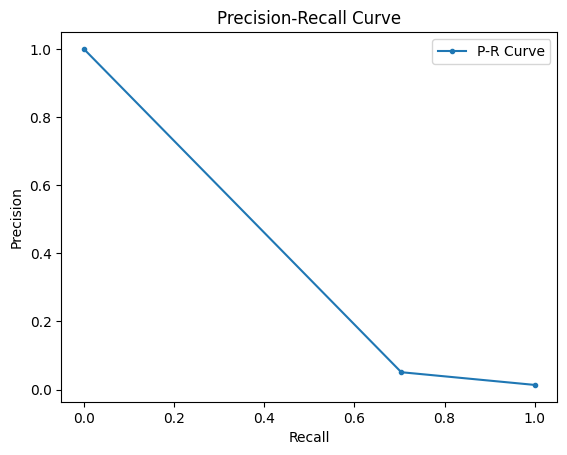

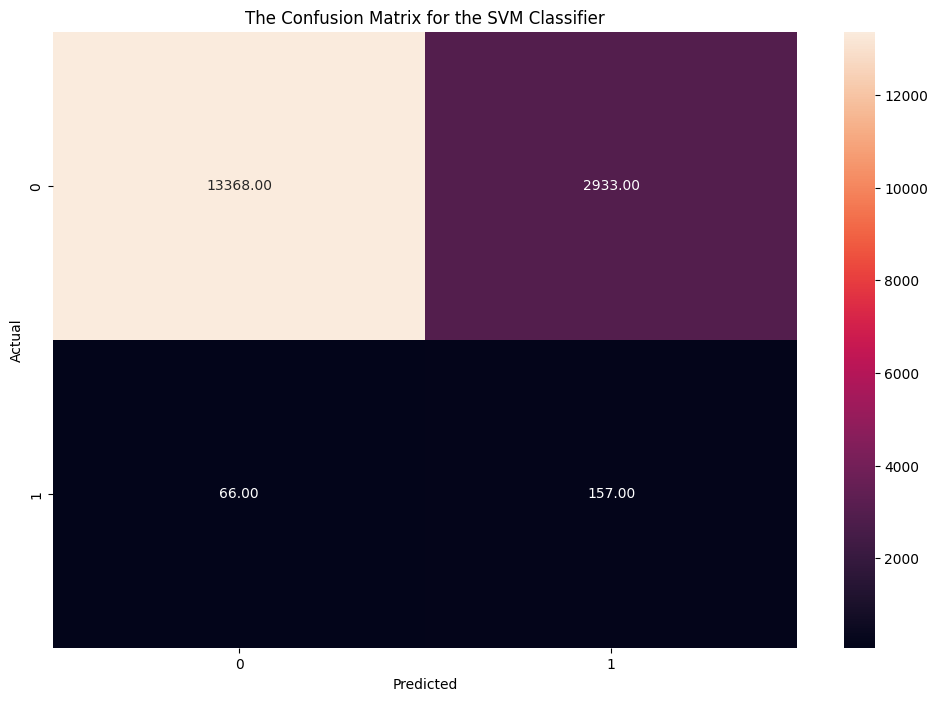

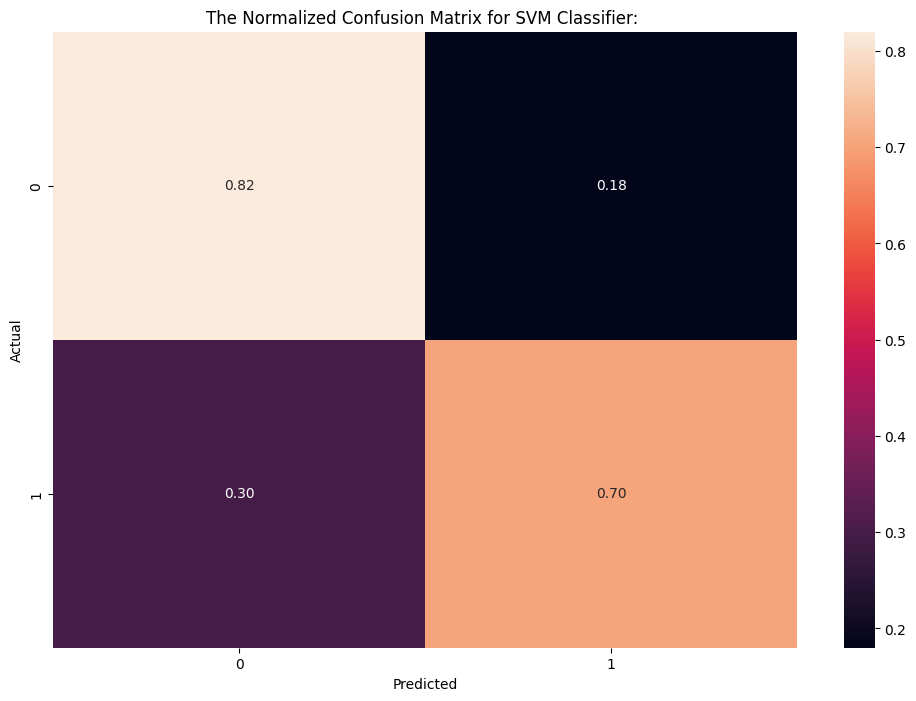

In [12]:
clf_svm.fit(X_train_resampled,y_train_resampled)
y_pred = clf_svm.predict(X_test)
print_metrics("SVM",y_test,y_pred)
print_confusion_matrix("SVM",y_test,y_pred)

For the Decision Tree Classifier: 

Accuracy :  0.8730
Precision :  0.5338
Recall :  0.7919
F1 Score :  0.5312


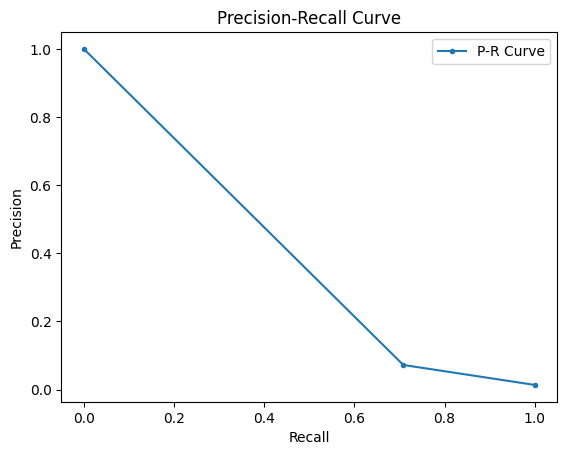

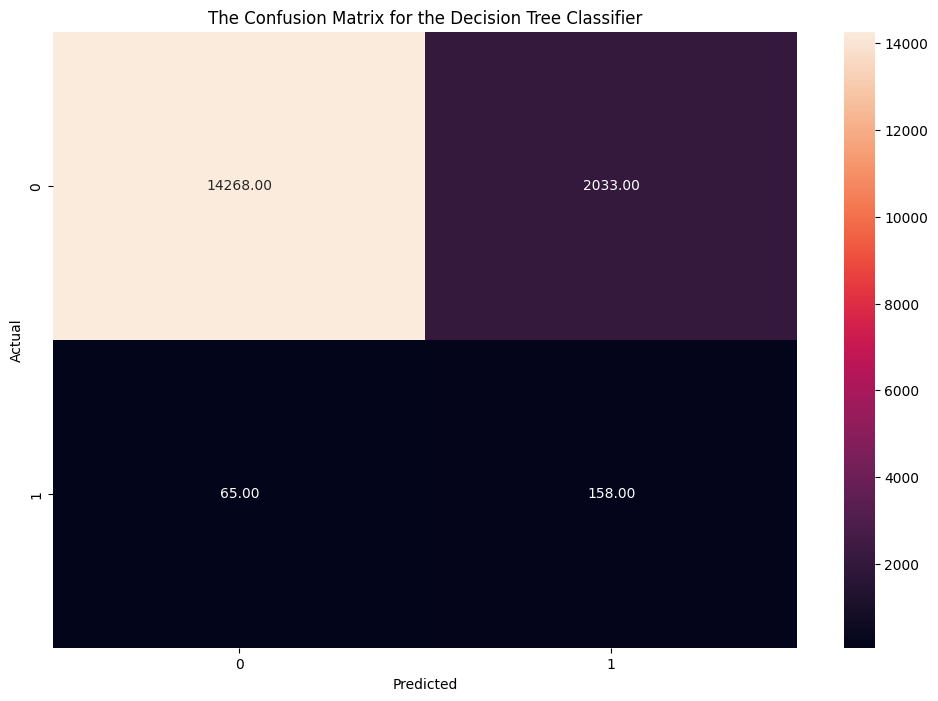

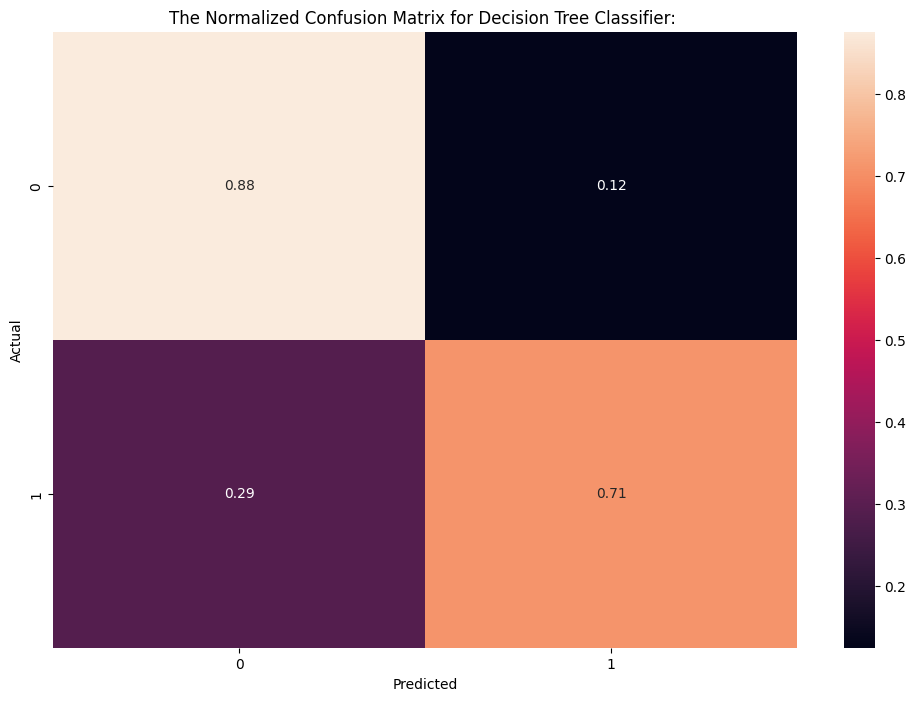

In [13]:
w_train = compute_sample_weight('balanced',y_train_resampled)
# training the model using the oversampled dataset
clf_dt.fit(X_train_resampled,y_train_resampled, sample_weight = w_train)
# testing the model using the imbalanced dataset
y_pred = clf_dt.predict(X_test)
print_metrics("Decision Tree",y_test,y_pred)
print_confusion_matrix("Decision Tree",y_test,y_pred)

For the Random Forest Classifier: 

Accuracy :  0.9242
Precision :  0.5594
Recall :  0.8377
F1 Score :  0.5853


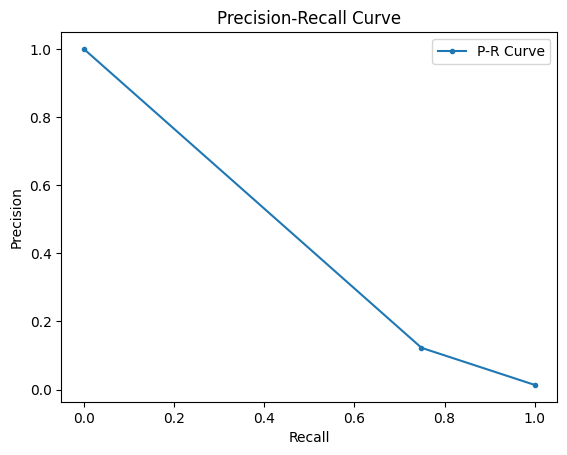

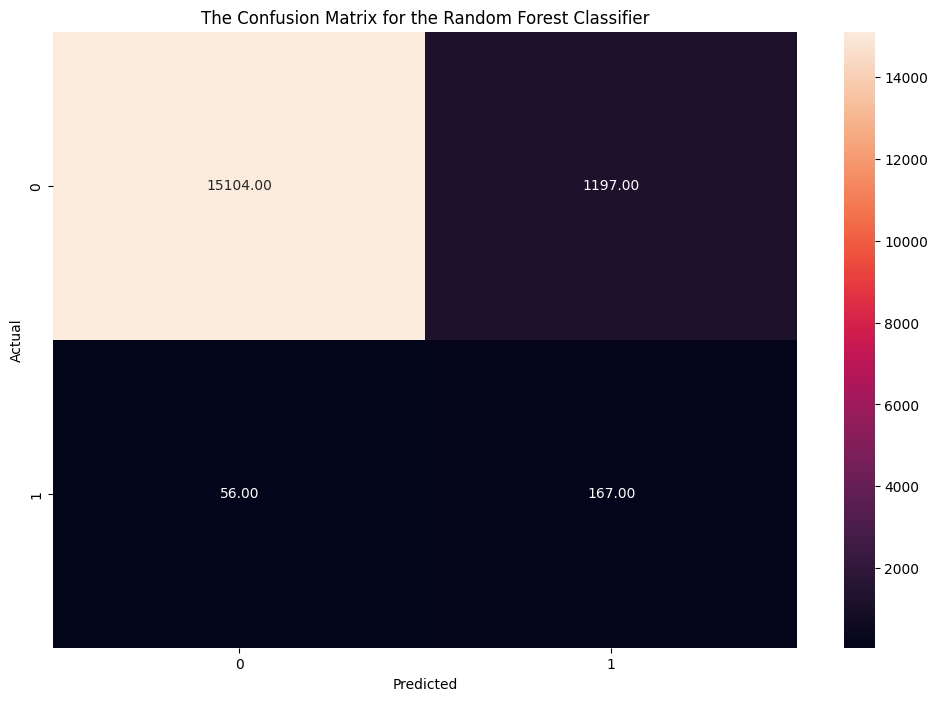

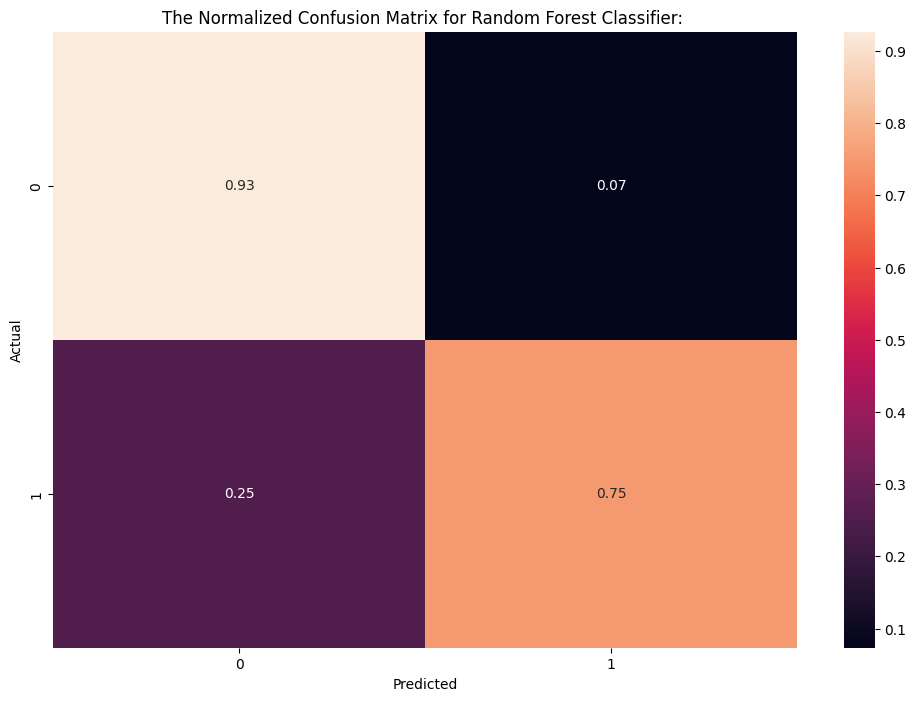

In [14]:
# training the model using the oversampled dataset
clf_rf.fit(X_train_resampled,y_train_resampled, sample_weight = w_train)
# testing the model using the imbalanced dataset
y_pred = clf_rf.predict(X_test)
print_metrics("Random Forest",y_test,y_pred)
print_confusion_matrix("Random Forest",y_test,y_pred)

For the Random Forest Resampled Classifier: 

Accuracy :  0.8338
Precision :  0.8457
Recall :  0.8338
F1 Score :  0.8324


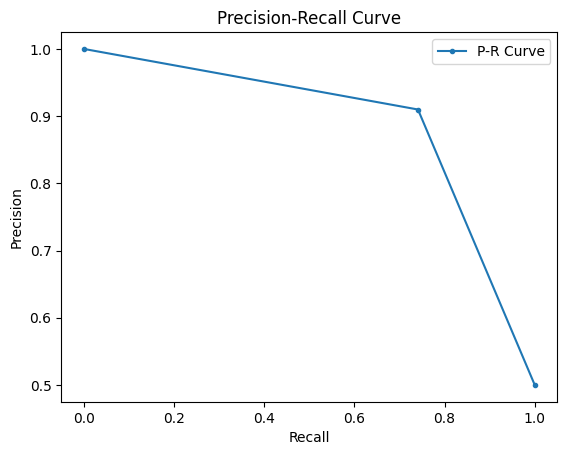

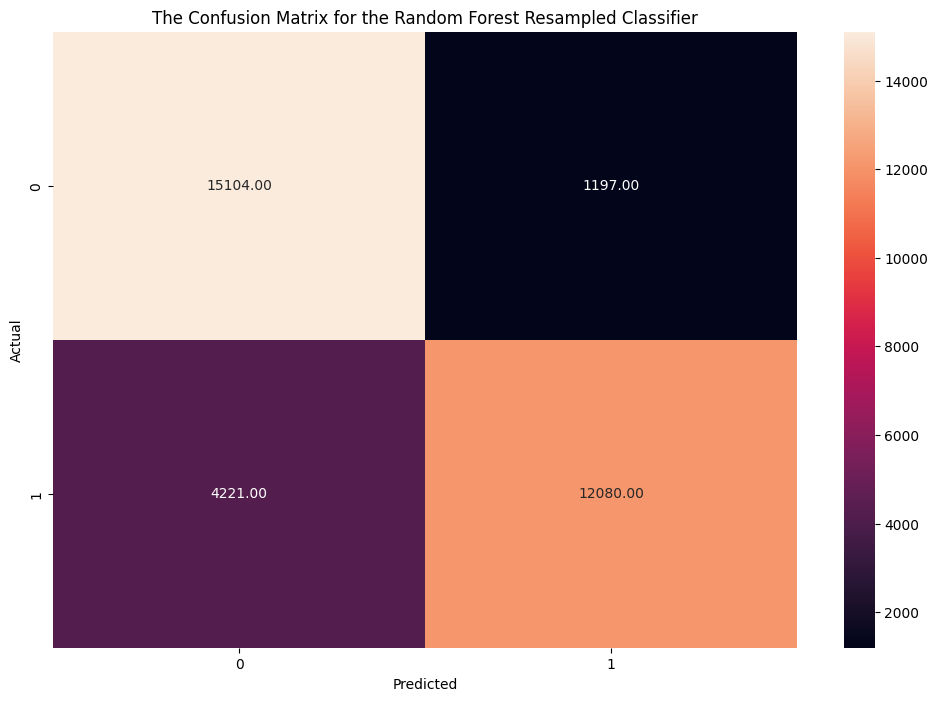

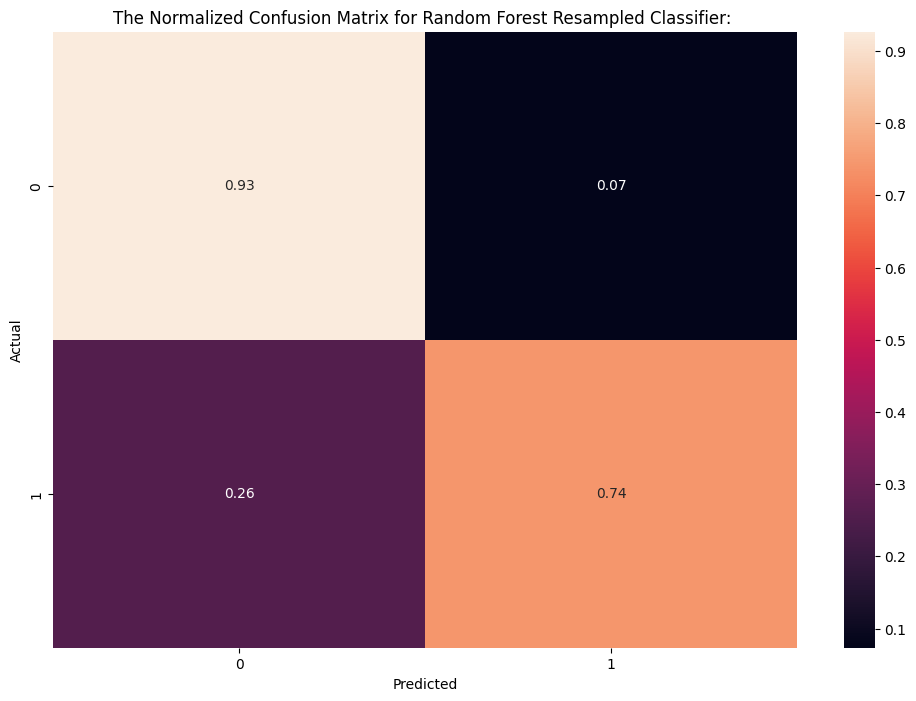

In [15]:
# training the model using the oversampled dataset
clf_rf.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_rf.predict(X_test_resampled)
print_metrics("Random Forest Resampled",y_test_resampled,y_pred)
print_confusion_matrix("Random Forest Resampled",y_test_resampled,y_pred)

For the XGBoost Classifier: 

Accuracy :  0.9367
Precision :  0.5648
Recall :  0.8087
F1 Score :  0.5955


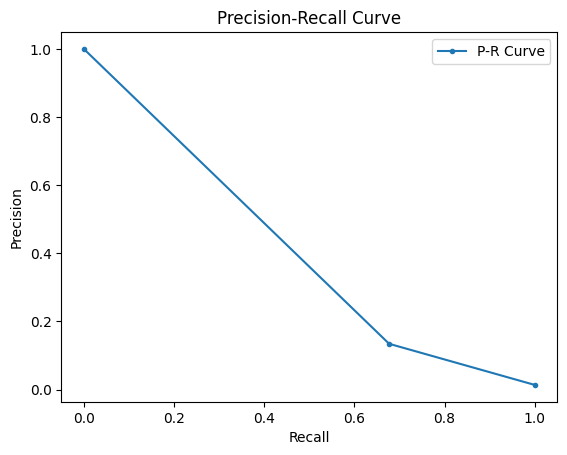

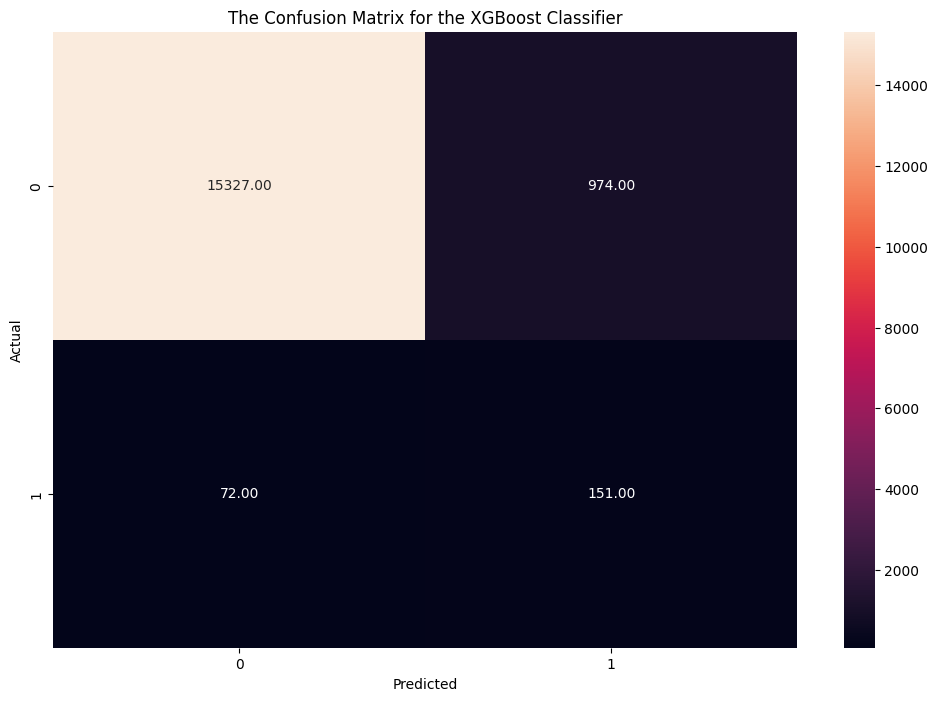

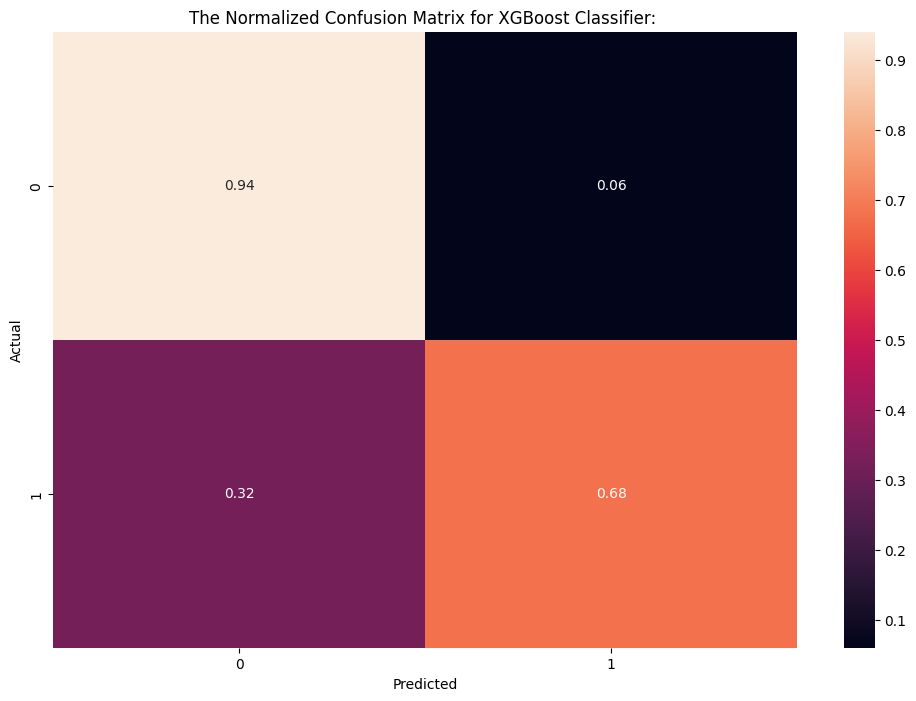

In [16]:
clf_xgb.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_xgb.predict(X_test)
print_metrics("XGBoost",y_test,y_pred)
print_confusion_matrix("XGBoost",y_test,y_pred)

For the Logistic Regression Classifier: 

Accuracy :  0.9228
Precision :  0.5377
Recall :  0.6999
F1 Score :  0.5504


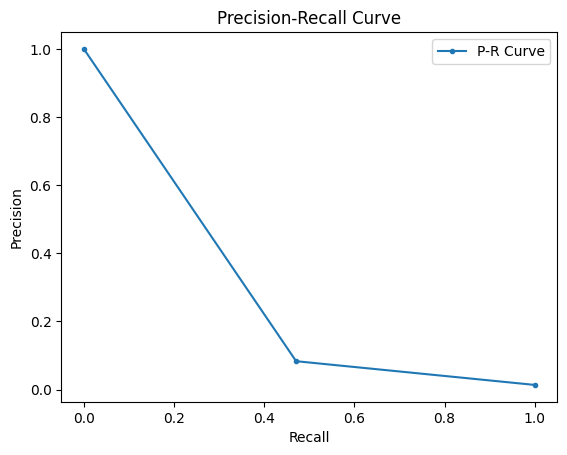

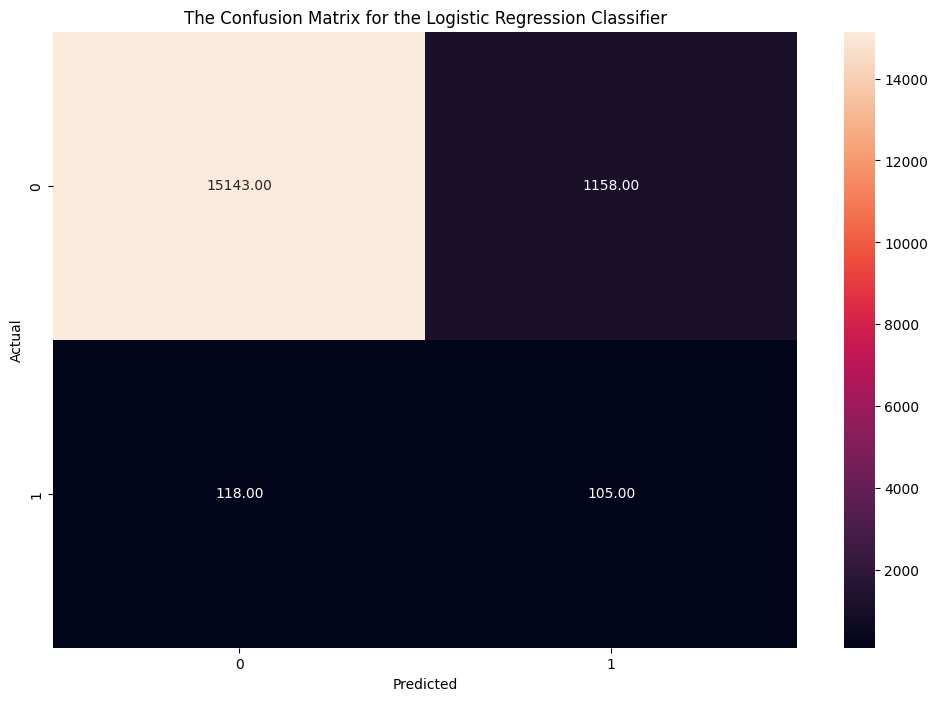

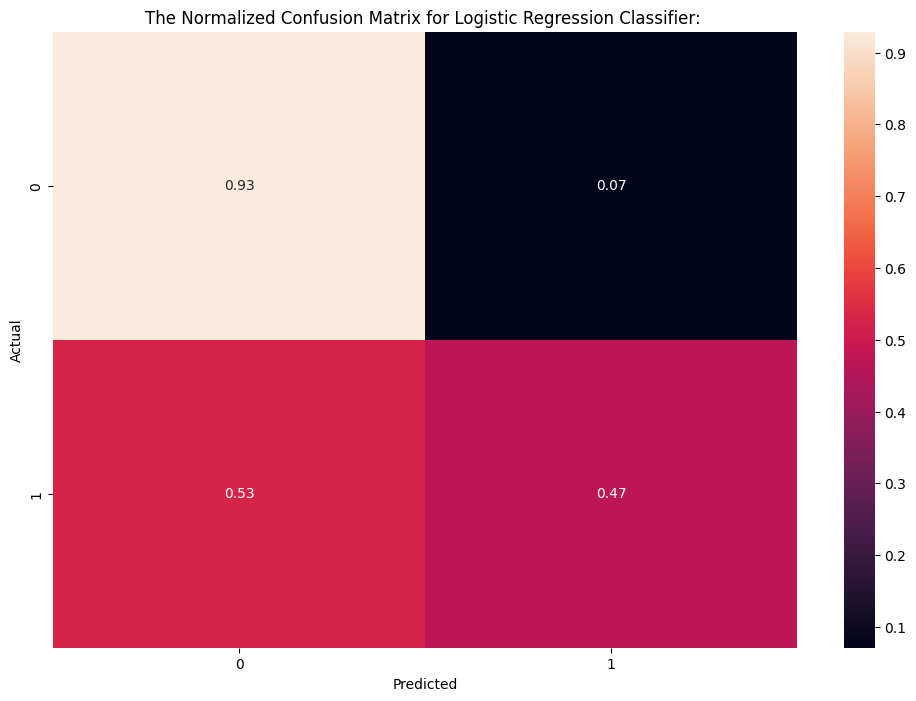

In [17]:
clf_lr.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_lr.predict(X_test)
print_metrics("Logistic Regression",y_test, y_pred)
print_confusion_matrix("Logistic Regression", y_test, y_pred)